In [1]:
## you may require: pip install python-igraph 
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
datadir = '../Datasets/'

In [2]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [3]:
## To produce LaTeX from a DataFrame
#df = df.round(decimals=3)
#print(df.to_latex(index=False))
#print(df.to_latex(index=True))

## US Airport Volume of Passengers

In [4]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

In [5]:
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()

In [6]:
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


In [7]:
## Build smaller subgraph for California (you can try other states)
hva = [v for v in g.vs() if v['state'] == 'CA']
G = g.subgraph(hva)

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')


22 nodes and 134 directed edges


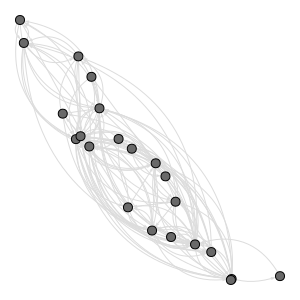

In [8]:
## plot using lat/lon as layout
ly = ig.Layout(G.vs['layout'])
ly.mirror(1)
ig.plot(G, bbox=(0,0,300,300), layout=ly)

In [9]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

In [10]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [11]:
## compute several centrality measures
C = pd.DataFrame({'airport':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head()
df

/Users/francois/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at /Users/travis/build/igraph/python-igraph/vendor/source/igraph/src/centrality.c:2856
  


,airport,degree,pagerank,authority,hub,between,closeness
1,LAX,0.117413,0.214569,1.000000,1.000000,0.506905,0.318182
0,SFO,0.089682,0.173044,0.969799,0.906676,0.362290,0.318182
2,SAN,0.079369,0.123509,0.688636,0.725553,0.014218,0.291667
3,OAK,0.046547,0.072727,0.473682,0.441193,0.030420,0.287671
5,SJC,0.041946,0.066523,0.415783,0.389968,0.047324,0.300000


In [12]:
## Remark: this agres with intuition; note however that SAN has high values ... 
## except for betweenness, 
## short path therefore mainly go via LAX and SFO.

In [13]:
df = Cs.tail()
df

,airport,degree,pagerank,authority,hub,between,closeness
17,CEC,4.012818e-04,0.007573,4.616790e-03,0.004542,0.000794,0.265823
18,IPL,2.823089e-04,0.007259,3.997932e-03,0.003833,0.000000,0.250000
19,MCE,3.090720e-05,0.045455,1.212388e-17,0.000000,0.000000,0.047619
20,VIS,3.090720e-05,0.045455,6.061940e-18,0.000000,0.000000,0.047619
21,NZY,8.915539e-07,0.006818,3.030970e-18,0.000023,0.000000,0.250000


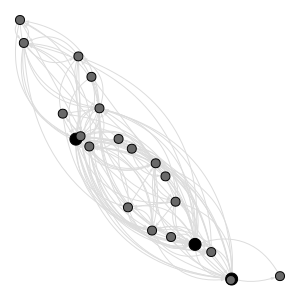

In [14]:
## highlight top-3 airports w.r.t. pagerank
G.vs()['prk'] = C['pagerank']
for x in np.argsort(G.vs()['prk'])[-3:]:
    G.vs()[x]['color'] = cls[2]
    G.vs()[x]['size'] = sz[2]
ig.plot(G,'California.eps',bbox=(0,0,300,300),layout=ly)

In [15]:
## rank-based correlation between measures
df = C.corr('kendall')
df

,degree,pagerank,authority,hub,between,closeness
degree,1.000000,0.773913,0.989156,0.973913,0.708075,0.811692
pagerank,0.773913,1.000000,0.763559,0.747826,0.578493,0.589918
authority,0.989156,0.763559,1.000000,0.980480,0.697305,0.801081
hub,0.973913,0.747826,0.980480,1.000000,0.698819,0.820563
between,0.708075,0.578493,0.697305,0.698819,1.000000,0.854544
closeness,0.811692,0.589918,0.801081,0.820563,0.854544,1.000000


minimal coreness: 1
maximal coreness: 13


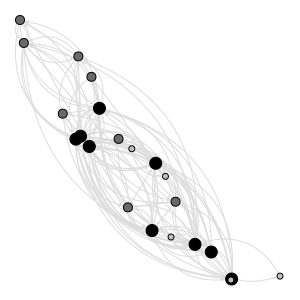

In [16]:
G.vs['color'] = cls[1]
G.vs['size'] = sz[1]
G.vs()['core'] = G.coreness()
Mc = np.max(G.vs()['core'])
mc = np.min(G.vs()['core'])
print('minimal coreness:',mc)
print('maximal coreness:',Mc)
for v in G.vs():
    if v['core'] == Mc:
        v['color'] = cls[2]
        v['size'] = sz[2]
    if v['core'] <= mc+1:
        v['color'] = cls[0]
        v['size'] = sz[0]
ig.plot(G,"California_coreness.eps",bbox=(0,0,300,300),layout=ly)

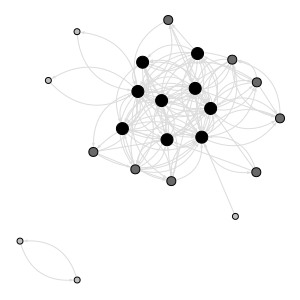

In [17]:
## the above uses the geographical layout, so it is not clear what is going on
## let's use a force directed layout
c = [1 if v['core']==13 else 2 if v['core']==2 else 0 for v in G.vs()]
ly = G.layout_kamada_kawai()
ig.plot(G,"California_kamada.eps",bbox=(0,0,300,300),layout=ly)

/Users/francois/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at /Users/travis/build/igraph/python-igraph/vendor/source/igraph/src/centrality.c:2856
  """Entry point for launching an IPython kernel.


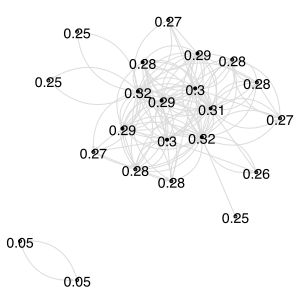

In [18]:
ix = np.round(G.closeness(),decimals=2)
G.vs['size'] = 3
ig.plot(G,"California_closeness.eps",vertex_label=ix,layout=ly,bbox=(0,0,300,300))

In [19]:
## now the 13-core is clearly appearing, and we aso observe a small connected component 
## that was buried in the previous viz.

## vertices in 13-core 
## note that there are less than 14 nodes, this is an interesting remark and
## it is because we consider both in and out-going edges by default for  directed graph.
V = [v['name'] for v in G.vs() if v['core']==Mc]
print(V)

['SFO', 'LAX', 'SAN', 'OAK', 'SNA', 'SJC', 'SMF', 'FAT', 'SBA']


In [20]:
## comparing coreness with other centrality measures
C['coreness'] = G.vs['core']
df = C.groupby('coreness').median()
df

,degree,pagerank,authority,hub,between,closeness
coreness,,,,,,
1,8.915539e-07,0.006818,3.030970e-18,0.000023,0.000000,0.250000
2,1.566080e-04,0.026549,1.998966e-03,0.001917,0.000000,0.148810
4,8.213523e-04,0.008181,1.059152e-02,0.010761,0.000000,0.259259
5,1.400697e-03,0.008987,1.963421e-02,0.019165,0.000000,0.265823
6,1.196201e-03,0.008752,1.571287e-02,0.015971,0.000000,0.269231
8,4.012818e-04,0.007573,4.616790e-03,0.004542,0.000794,0.265823
9,3.015021e-03,0.011944,3.401302e-02,0.034083,0.004365,0.276316
11,1.356318e-03,0.008885,1.595097e-02,0.016089,0.009524,0.283784
13,4.194644e-02,0.066523,4.157833e-01,0.389968,0.035692,0.300000


In [21]:
## group in 3 categories
G.vs()['Core'] = ['low' if v['core']<=2 else 'high' if v['core']==13 else 'mid' for v in G.vs()]
C['Coreness'] = G.vs['Core']
df = C.groupby('Coreness').mean()
df = df.drop('coreness',axis=1)
df

,degree,pagerank,authority,hub,between,closeness
Coreness,,,,,,
high,0.051587,0.089611,0.483076,0.472181,0.125078,0.299553
low,0.000175,0.022526,0.002297,0.002210,0.000000,0.169048
mid,0.001740,0.010109,0.020364,0.020486,0.003930,0.272069


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


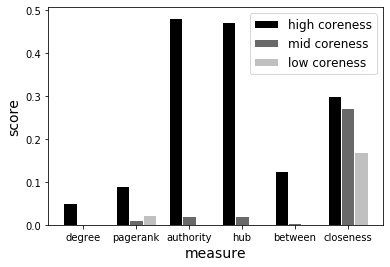

In [22]:
## grouped barplot

bh = np.array(df.loc[['high']])[0]
bm = np.array(df.loc[['mid']])[0]
bl = np.array(df.loc[['low']])[0]
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(bh))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 # Make the plot
plt.bar(r1, bh, color=cls[2], width=barWidth, edgecolor='white', label='high coreness')
plt.bar(r2, bm, color=cls[1], width=barWidth, edgecolor='white', label='mid coreness')
plt.bar(r3, bl, color=cls[0], width=barWidth, edgecolor='white', label='low coreness')
 
# Add xticks on the middle of the group bars
plt.xlabel('measure',fontsize=14)
plt.xticks([r + barWidth for r in range(len(bh))], df.columns, fontsize=10)
plt.ylabel('score',fontsize=14) 
# Create legend & Show graphic
plt.legend(fontsize=12)
#plt.show()
plt.savefig('California_core_vs_measures.eps',dpi=1200)

In [23]:
## Simulation example
def spread(g, alpha=0.1):
    n = g.vcount()
    I = np.diag(np.repeat(1,n))
    A = np.array(g.get_adjacency().data)
    One = np.ones((n,1))
    X = np.linalg.inv(I-alpha*np.transpose(A))
    Y = np.reshape(X.dot(One)/n,n)
    return np.sum(Y)
def spread_delta_centrality(g, alpha=0.1):
    dc = []
    spr = spread(g, alpha=alpha)
    for i in g.vs():
        G = g.copy()
        el = g.incident(i, mode='ALL')
        G.delete_edges(el)
        dc.append((spr-spread(G, alpha=alpha))/spr)
    return dc

In [24]:
G.vs['delta'] = spread_delta_centrality(G, alpha=.1)
DC = pd.DataFrame(np.transpose([G.vs['name'],G.vs['delta'],G.vs['color']]),columns=['airport','delta','color'])
DC.sort_values(by='delta',ascending=False, inplace=True)
DC.head()

,airport,delta,color
0,SFO,0.5781442103552328,black
1,LAX,0.5765987683670659,black
6,SMF,0.5118313161868462,black
5,SJC,0.46740475552186794,black
2,SAN,0.4327191367894437,black


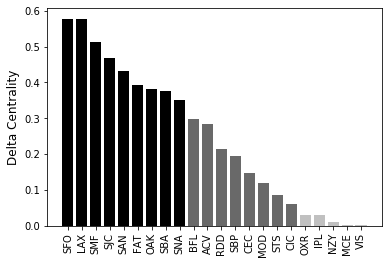

In [25]:
heights = [float(x) for x in DC['delta']]
bars = DC['airport']
y_pos = range(len(bars))
plt.bar(y_pos, heights, color=DC['color'] )
# Rotation of the bars names
plt.ylabel('Delta Centrality',fontsize=12)
plt.xticks(y_pos, bars, rotation=90)
plt.yticks()
plt.savefig('California_delta.eps',dpi=1200)

## Group centrality, centralization

Back to US graph, 
- which states have highest delta centralities w.r.t. efficiency?
- what about centralization for each state subgraph?

In [26]:
## group delta centrality
def efficiency(g):
    n = g.vcount()
    s = 0
    for i in range(n-1):
        v = g.get_shortest_paths(i)
        s += np.sum([1/len(x) for x in v[i+1:] if len(x)>0])
    return s/(n*(n-1))

import warnings
warnings.filterwarnings('ignore')

## group centrality -- by state
states = list(set(g.vs()['state']))
eff_us = efficiency(g)
dc = []
for s in states:
    v = [x for x in g.vs() if x['state']==s]
    G = g.copy()
    e = []
    for x in v:
        e.extend(g.incident(x))
    G.delete_edges(e)
    dc.append((eff_us-efficiency(G))/eff_us)

DC = pd.DataFrame({'state':states, 'delta_centrality':dc})
DC = DC.sort_values(by='delta_centrality', ascending=False)
df = DC.head(3)
df

,state,delta_centrality
13,TX,0.105294
15,CA,0.086511
32,FL,0.068314


In [27]:
df = DC.tail(3)
df

,state,delta_centrality
28,RI,0.004402
46,NH,0.004247
3,DE,0.001028


In [28]:
## group centralization (using PageRank) -- by state
states = list(set(g.vs()['state']))
pr = []
st = []
for s in states:
    v = [x for x in g.vs() if x['state']==s]
    if len(v)>5:
        G = g.subgraph(v)
        p = G.pagerank()
        pr.append(np.max(p) - np.mean(p))
        st.append(s)

DC = pd.DataFrame({'State':st, 'Pagerank Centralization':pr})
DC = DC.sort_values(by='Pagerank Centralization', ascending=False)
df = DC.head(3)
df


,State,Pagerank Centralization
34,MN,0.333972
31,AZ,0.266335
32,GA,0.263817


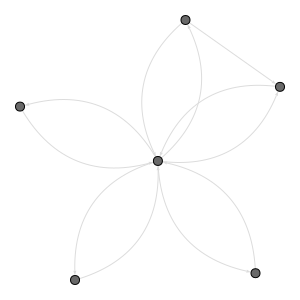

In [29]:
v = [x for x in g.vs() if x['state']=='MN']
G = g.subgraph(v)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
ig.plot(G, 'central_MN.eps', bbox=(0,0,300,300))


In [30]:
G.vs['name']

['MSP', 'DLH', 'RST', 'BJI', 'STC', 'BRD']

In [31]:
## state with one big hub city: Minneapolis
G.vs['city']

['Minneapolis', 'Duluth', 'Rochester', 'Bemidji', 'St. Cloud', 'Brainerd']

In [32]:
df = DC.tail(3)
df

,State,Pagerank Centralization
13,WY,0.046812
18,AR,0.043340
23,MT,0.035195


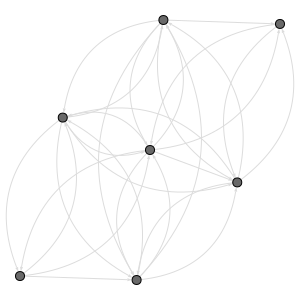

In [33]:
v = [x for x in g.vs() if x['state']=='MT']
G = g.subgraph(v)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
ig.plot(G, 'central_MT.eps', bbox=(0,0,300,300))

In [34]:
## no big city
G.vs['city']

['Bozeman',
 'Billings',
 'Missoula',
 'Kalispell',
 'Helena',
 'Great Falls',
 'Butte']

In [35]:
## what about California?
DC.tail(5)

,State,Pagerank Centralization
11,CA,0.072637
22,FL,0.052791
13,WY,0.046812
18,AR,0.043340
23,MT,0.035195
